### Create the data

https://cs231n.github.io/convolutional-networks/
https://medium.com/apache-mxnet/multi-channel-convolutions-explained-with-ms-excel-9bbf8eb77108

In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
from cycler import cycler
import matplotlib.style
import matplotlib as mpl
from mpl_toolkits import mplot3d 

nn.Module comes in handy while writing many DL model. For example when you are trying to code Maxout Network as defined in the paper [Maxout Networks] (https://arxiv.org/pdf/1302.4389.pdf 44).
https://github.com/pytorch/pytorch/commit/c7c8aaa7f040dd449dbc6aca9204b2f943aef477
https://discuss.pytorch.org/t/multiple-parallel-fully-connected-layers-type-torch-cuda-floattensor-but-found-type-torch-floattensor/37810
https://www.geeksforgeeks.org/single-neuron-neural-network-python/
https://rhettinger.wordpress.com/2011/05/26/super-considered-super/


In [2]:
%matplotlib notebook
import glob, os, os.path
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import bisect
import scipy.sparse as sparse  #for baseline subtraction
from matplotlib import rc
rc('mathtext', default='regular')
import h5py

In [3]:
'''Definitions'''

def gaussian(x, x0, r, a, b):
    y = b + a*np.exp(-(x-x0)**2/(2*r**2))
    return y

def PseudoVoigtFunction(WavNr, Pos, Amp, GammaL, FracL):
    SigmaG = GammaL / np.sqrt(2*np.log(2)) # Calculate the sigma parameter  for the Gaussian distribution from GammaL (coupled in Pseudo-Voigt)
    LorentzPart = Amp / np.pi * (GammaL / ((WavNr - Pos)**2 + GammaL**2)) # Lorentzian distribution
    GaussPart = Amp / (np.sqrt(2*np.pi) * SigmaG) * np.exp( -(WavNr - Pos)**2 / (2 * SigmaG**2)) # Gaussian distribution
    Fit = FracL * LorentzPart + (1 - FracL) * GaussPart # Linear combination of the two parts (or distributions)
    return Fit

#baseline subtraction based on Asymetric Least Square Smoothing
#https://zanran_storage.s3.amazonaws.com/www.science.uva.nl/ContentPages/443199618.pdf
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Function which extracts the number of all XYfiles in the directory.    
run_no=0
def get_number_XYfiles(run_no):
    directory = os.listdir('data/')
    number_XYfiles = run_no
    for Dir in directory:
        number_XYfiles = number_XYfiles+1
    return(number_XYfiles)

In [4]:
# show the number of XYfiles found in the directory
total_XYfiles = get_number_XYfiles(run_no)
print(total_XYfiles)
total_XYfiles=350 #[Pt=1084, MgFeOB1_263]
print('The number of XYfiles within the chosen run is:', total_XYfiles)
%pwd
%mkdir -p ClassificationFigures
save_figures_to = '../ClassificationFigures/'

350
The number of XYfiles within the chosen run is: 350


In [5]:
'''make sure that you have the right command directory selected'''
%cd /gpfs/exfel/data/user/sunyue/Downloads/Brockhauser_Sandor/L2_Beamtime2019_Fe200culet_fe80mg20/XY/
theta = [] 
I = []
baseline = []
Icorrect = []

test_y=total_XYfiles-2
for run_no in range(1,0+total_XYfiles):
    fileNO = str(run_no).zfill(4) 
    fname = 'l2_fe80mg20_ramp_00001_m1_'+str(run_no).zfill(4)+'.xy'
    thetas, Is = np.loadtxt(fname, skiprows=25, unpack=True) # reads all files in range and assigns 1st column to thetas and 2nd to Is
    I.append(Is) # attaches a new array each time to a copy of previous, not really necessary here
    idx1 = 0
    idx2 = 4050
#background subtraction
#parameters lam and p have to be adjusted by hand!
#try 10**2 < lam < 10**9
#    0.001 <  p  < 0.1
    lam = 100000
    p = 0.002
    baselines = baseline_als(Is[idx1:idx2], lam, p)
    baseline.append(baselines)
    Icorrected = Is[idx1:idx2] - baselines
    Icorrect.append(Icorrected)
#    if (run_no==15): 
#        print(thetas.size, Is.shape,type(I),np.shape(I),len(Icorrected),len(baselines),sep='\n')
    thetas = thetas[idx1:idx2]
    theta.append(thetas)

/gpfs/exfel/data/user/sunyue/Downloads/Brockhauser_Sandor/L2_Beamtime2019_Fe200culet_fe80mg20/XY


In [6]:
%cd -

/gpfs/exfel/data/user/sunyue/Spectra_classification_20201122


In [7]:
print(theta[0].shape,np.size(theta),len(theta),np.size(theta[0]))

(4023,) 1404027 349 4023


<IPython.core.display.Javascript object>


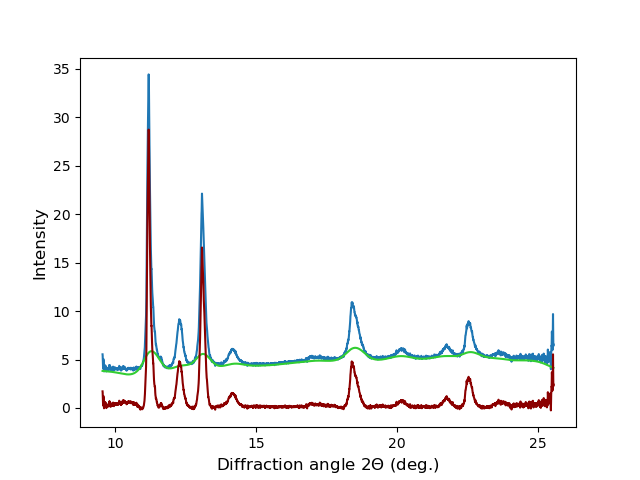

<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

In [8]:
plt.figure()
plt.plot(theta[98], I[98][idx1:idx2])
plt.plot(theta[98], baseline[98],color = 'limegreen')
plt.plot(theta[98], Icorrect[98], color = 'darkred')
#plt.plot(theta[0], I[0], color = 'red')
#plt.plot(theta[1500], I[1500][idx1:idx2])
#plt.plot(theta[1500], baseline[1500])
#plt.plot(theta[450], Icorrect[450], color = 'limegreen')
#plt.plot(theta[420], I[420], color = 'limegreen')
plt.ylabel('Intensity', fontsize = 12)
plt.xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 12)
plt.tight_layout

In [9]:
def minibatch_plot_data(X, y, ai1=-1,ai2=1,bi1=-1,bi2=1,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=2, cmap=plt.cm.rainbow)
#     plt.axis('square')
#     plt.axis(np.array((ai1, ai2, bi1, bi2)) * zoom)
#     if auto is True: plt.axis('equal')
    plt.axis('on') 
    
def minibatch_plot_model(mndinx1,mndinx2,mndiny1,mndiny2,X2, y2, model):
    model.cpu()
#     nx, ny = (200, 200)
#     x = np.linspace(mndinx1, mndinx2, nx)
#     y = np.linspace(mndiny1,mndiny2, ny)
    x = np.arange(mndinx1, mndinx2, 0.02)
    y = np.arange(mndiny1, mndiny2, 0.001)
    xx, yy = np.meshgrid(x, y)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
    minibatch_plot_data(X2, y2,mndinx1,mndinx2,mndiny1,mndiny2,zoom=1)

In [10]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', fontsize = 16,)
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
#     plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)

In [11]:
def set_default(figsize=(8, 8)):
#     plt.style.use(['dark_background', 'bmh'])
#     plt.rc('figure', facecolor='none')
    plt.rc('figure', figsize=figsize)
    
def yue_plot_data(X, y, axl,axr,byl,byh,d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
#     plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.set_ylabel('Intensity', fontsize = 16,)
    ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    #ax.set_ylim(-2,50)
    #ax.set_xlim(9.5,26)
    
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=0.6, cmap=plt.cm.rainbow)
    #plt.axis('auto')      
#     ax.spines['right'].set_visible(False) #remove right axis spine
#     ax.spines['top'].set_visible(False) # remove top axis spine  
    
    """
    X = X.cpu()
    y = y.cpu()
    plt.axis(np.array((axl, axr, byl, byh)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    plt.tight_layout()
    #_m, _c = 0, '.15'
    #plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    #plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)
    """
    """
    cmaps = [('Perceptually Uniform Sequential', [
                'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
             ('Sequential', [
                'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
             ('Sequential (2)', [
                'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
                'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
                'hot', 'afmhot', 'gist_heat', 'copper']),
             ('Diverging', [
                'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
                'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
             ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
             ('Qualitative', [
                'Pastel1', 'Pastel2', 'Paired', 'Accent',
                'Dark2', 'Set1', 'Set2', 'Set3',
                'tab10', 'tab20', 'tab20b', 'tab20c']),
             ('Miscellaneous', [
                'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
                'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
                'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
    """

def ys_plot_model(X, y, model):
    plt.figure(figsize=(8,8))
    bx = plt.subplot(111)
#     bx.set_ylabel('Intensity', fontsize = 16,)
#     bx.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
    plt.axis([axl, axr, byl, byh])
    
#     plt.rc('xtick',labelsize=16)
#     plt.rc('ytick',labelsize=16)
    
    model.cpu()
    X=X.cpu()
    mesh1 = np.arange(axl, axr, 0.01)
    mesh2 = np.arange(byl, byh, 0.01)
    xx, yy = np.meshgrid(mesh1, mesh2)
    
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float().cpu()
        Z = model(data).detach()
        #print(xx,Z.shape,Zt,data.shape)
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)     
    yue_plot_data(X, y, axl,axr,byl,byh)
    
    
def yue_plot_3D(X, X_axis):
    X = X.cpu()
    X_axis = X_axis.cpu()    
    
    fig = plt.figure(figsize = (10, 7)) 
    ax = plt.axes(projection ="3d") 

    # Creating plot 
    ax.scatter3D(X_axis.numpy(), X.numpy()[:, 0], X.numpy()[:, 1],s=0.3, color = "green"); 
    
    plt.title("Spectra 3D scatter plot") 
    ax.set_xlabel('X-axis', fontweight ='bold')  
    ax.set_ylabel('angle', fontweight ='bold')  
    ax.set_zlabel('intensity', fontweight ='bold') 

    # show plot 
    plt.show() 

In [12]:
set_default()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###  data for training

<IPython.core.display.Javascript object>


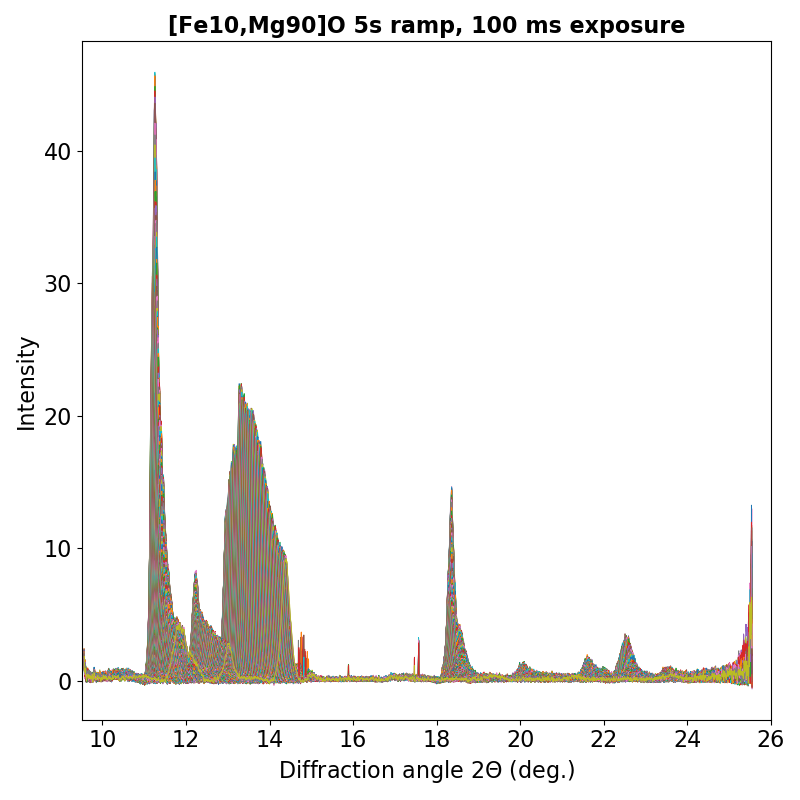

(4023,) 349 185


In [14]:
# data for training
#plotting various plots to show development of bcc -> hcp transition
plt.figure(figsize=(8,8))

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

# These are the colors that will be used in the plot
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

ax = plt.subplot(111)
N=len(theta[0])

X_1 = []# training: theta
X_2 = []# training: intensity
y   = []
global Ci,Ci_0,div_num,gap #indicates num of curves, and curves of class0.
div_num = 185 #indicates the boundary of spectral curves.
gap = 1 #20
Ci = 0  
Ci_0 = 0
X_axis=[] # used to store data for 3D plotting

for pct in range(0,total_XYfiles-1,gap):
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = 'limegreen' if pct <200 else 'blue')
    #ax.plot(theta[pct], Icorrect[pct]+6-pct/50., color = color_sequence[Ci])
#     ax.plot(theta[pct], Icorrect[pct]+6-pct/50.,lw=1)
    ax.plot(theta[pct], Icorrect[pct],lw=0.6)
 
    #testX = torch.FloatTensor(theta[pct])
    #testX = torch.cat((testX),1)
    
    Icorrect_t = Icorrect[pct]
#     Icorrect_t = Icorrect[pct]+6-pct/50.
    theta_t = theta[pct]
    X_1.append(theta_t)
    X_2.append(Icorrect_t)
    X_axis.append(np.ones(N)*pct) 
    
    Ci += 1
    if pct <div_num:
        Ci_0 += 1
    #y.append(torch.zeros(1,size(theta[pct])) if pct < 200 else torch.ones(1,size(theta[pct]))

             
print(X_1[0].shape,Ci,Ci_0)


ax.set_ylabel('Intensity', fontsize = 16,)
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
# ax.set_ylim(-2,45)
ax.set_xlim(9.5,26)

plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure', fontsize=16, fontweight='bold')

# ax.spines['right'].set_visible(False) #remove right axis spine
# ax.spines['top'].set_visible(False) # remove top axis spine
plt.tight_layout()
plt.savefig(save_figures_to+"Original data used for training.png", bbox_inches='tight', dpi=600)

In [15]:
(np.size(X_1)), len(X_1), 349*4023

(1404027, 349, 1404027)

<IPython.core.display.Javascript object>


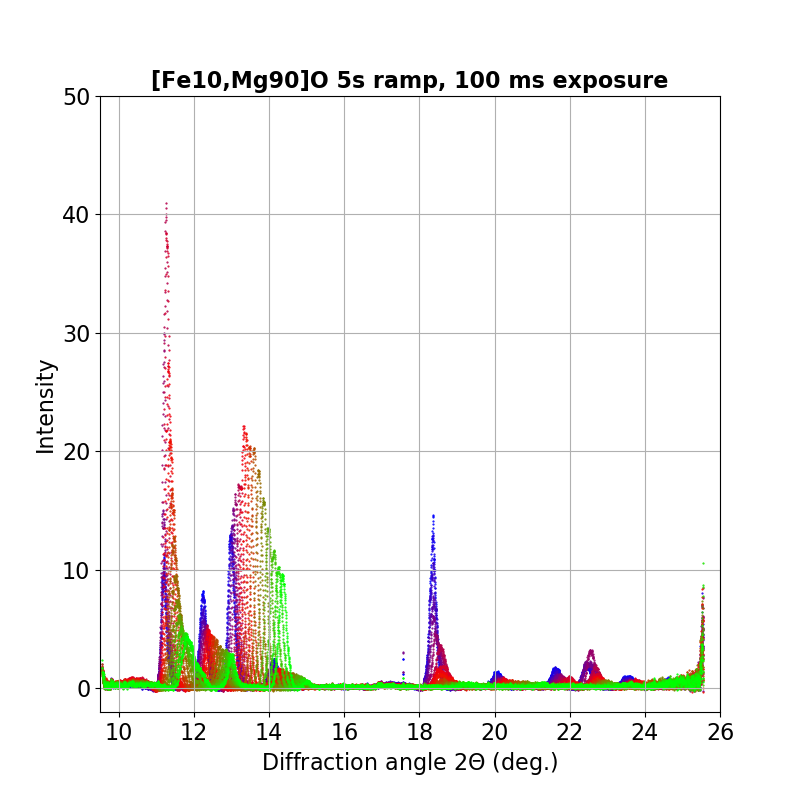

In [16]:
#plotting spectra in another way
plt.figure(figsize=(8,8))
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

ax = plt.subplot(111)
t_gap=20 # this parameter decide the number of spectral curves for test.

import matplotlib.cm as cm
colors = cm.brg(np.linspace(0, 1, len(range(0,total_XYfiles-1,t_gap)))) # or gist_rainbow

pos_d=0
for pct,cc in zip(range(0,total_XYfiles-1,t_gap),colors):
    pct = pct+pos_d
    plt.scatter(theta[pct], Icorrect[pct], color=cc,s=0.3)
    
ax.set_ylabel('Intensity', fontsize = 16,)
ax.set_xlabel('Diffraction angle 2$\Theta$ (deg.)', fontsize = 16)
ax.set_ylim(-2,50)
ax.set_xlim(9.5,26)
plt.grid(True)
plt.title('[Fe10,Mg90]O 5s ramp, 100 ms exposure', fontsize=16, fontweight='bold')
plt.savefig(save_figures_to+"Spectra data for testing (manually classified).png", bbox_inches='tight', dpi=600)

plt.tight_layout()


In [17]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# # X = sc.fit(X_2)
# X_i = sc.fit_transform(X_2)
# # X_train = sc.fit_transform(X_2)
# # X_test = sc.transform(X_test)

In [18]:
standard_flag = 0
if standard_flag:
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_i = sc.fit_transform(X_2)
    # X = sc.fit(X_2)
    # X_train = sc.fit_transform(X_2)
    # X_test = sc.transform(X_test)
else:
    X_i = X_2 - np.mean(X_2,axis=0)

In [19]:
print(X_i.mean(axis=0))
print(X_i.std(axis=0))

[ 4.19912433e-17  2.41767765e-17  3.10480708e-16 ...  1.67710481e-15
 -2.09828970e-15  3.90645809e-16]
[0.25872645 0.23615664 0.23176907 ... 1.77121769 1.77999433 2.89521417]


In [20]:
PCA_NUM_COMP = len(X_i)-1
print(PCA_NUM_COMP)

348


In [21]:
from sklearn.decomposition import PCA
Sum_Explained_variance =.99
pca = PCA(Sum_Explained_variance)
# pca = PCA(n_components=240)
# pca = PCA(n_components=PCA_NUM_COMP)
X2_data =pca.fit_transform(X_i)
# X2_test = pca.transform(X_test)
N_Compents=pca.n_components_ 
print(X2_data.shape)
print(N_Compents)

(349, 13)
13


In [22]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance.shape)

(13,)


<IPython.core.display.Javascript object>


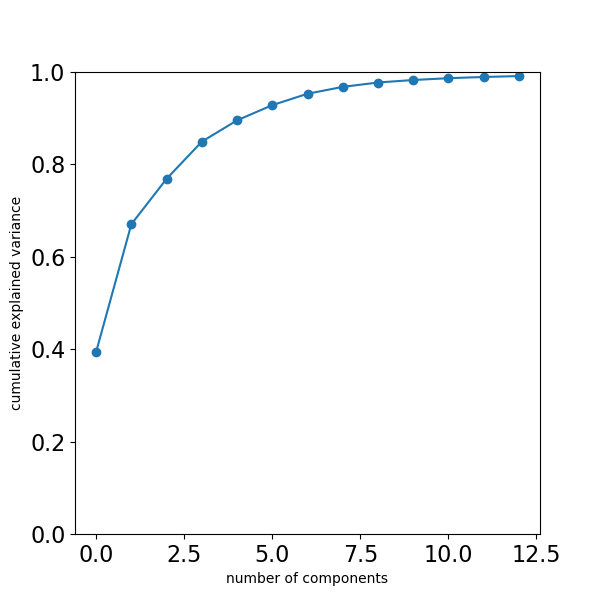

In [23]:
plt.figure(figsize=(6,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'o-')
plt.xlabel('number of components');
plt.ylim(0,1.0)
plt.ylabel('cumulative explained variance');

<IPython.core.display.Javascript object>


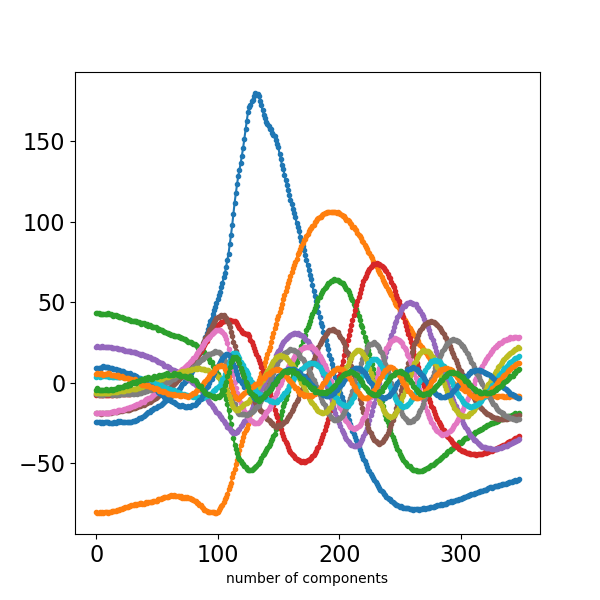

(349, 13)


<IPython.core.display.Javascript object>


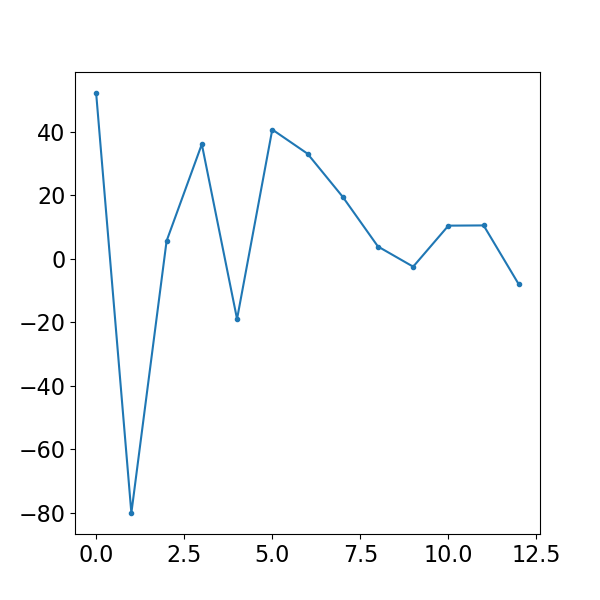

(2, 13)


In [24]:
plt.figure(figsize=(6,6))
plt.plot(X2_data,'.-')
plt.xlabel('number of components');
print(X2_data.shape)
plt.figure(figsize=(6,6))
print(X2_data[-3:-1].shape)
plt.plot(X2_data[100],'.-')

In [25]:
type(X2_data)

numpy.ndarray

# pick certern extreme curves and add some random noise to train the model

In [26]:
# # """
# N = N_Compents


# p_num=[0,32 ,8, 26, 14, 30, 2 ,34,3,31,4, 21,10,23] #1 #5  class 0 class 1 class 0
# N_TrainOrg = len(p_num)
# Train_Gap = 10
# X_2=torch.FloatTensor(X2_data)
# Xtemp = torch.zeros(len(p_num),N_Compents)
# X_Extrem_tmp = torch.empty(0,N_Compents)
# for i in range(len(p_num)):
#     Xtemp[i] = X_2[Train_Gap*p_num[i]] # intensity
#     print(X_Extrem_tmp.shape,Xtemp[i].shape)
#     X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp[i],(1,-1))),0)
# print(Xtemp.shape)

# X_Extrem= torch.empty(0,N_Compents)
# X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.

# plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
# # ax.plot(Xtemp[0],lw=0.6,color='red')
# # ax.plot(Xtemp[2],lw=0.6,color='blue')
# N_sim=50 # simulated spectra 

# for n in range(N_sim):
#     X_Extrem_tmp = torch.empty(0,N_Compents)
#     seed = n*1000
#     random.seed(seed)
#     torch.manual_seed(seed)
#     for j in range(len(p_num)):
#         for i in range(D_len):
#             Xtemp[j,i] = Xtemp[j,i] +random.random()/10
#         ax.plot(Xtemp[j],'.-',color='red' if j/2==0 else 'blue')
#         X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp[j],(1,-1))),0)
#     X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.
# #     y_Extrem_tmp=torch.cat((ytemp1,ytemp2),0)
# #     y_Extrem    =torch.cat((y_Extrem,y_Extrem_tmp),0)
# # one row for one spectral curve:
# print((X_Extrem).shape)

# plt.tight_layout()


# ###### """ compute y2 class label================
# N_Train=N_TrainOrg*N_sim+N_TrainOrg

# # X2 = torch.zeros(N2 * N_Train, D*B).to(device)
# # y2 = torch.zeros(N2 * N_Train, B, dtype=torch.long).to(device)
# # print(X2.shape,X_Extrem.shape)
# # X2[0,0:1] = X_Extrem[0,0:1]

# global X2,y2  
# X2 = X_Extrem.to(device)
# # y2 = torch.FloatTensor([0, 1] * (N_sim+int(N_TrainOrg/2))).to(device)
# y2 = torch.FloatTensor([0, 1] * (int(N_Train/2))).to(device)

# y2 = torch.reshape(y2,(-1,1))
# print(X2.shape,y2.shape,type(y2))
# # y2 = torch.cat([torch.zeros(1),torch.ones(1)]).to(device)

# #  ===============================method 2============================
# # y2_true = torch.empty(0)  # (batch_size, 1) 
# # y2 = torch.FloatTensor([torch.zeros(1),torch.ones(1)]).to(device)
# # print(y2.shape)
# # for n in range((N_sim+1)):
# #     y2_true= torch.cat([y2_true, y2], dim=0)  
# # print(y2_true.shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
torch.Size([0, 13]) torch.Size([13])
torch.Size([1, 13]) torch.Size([13])
torch.Size([2, 13]) torch.Size([13])
torch.Size([3, 13]) torch.Size([13])
torch.Size([4, 13]) torch.Size([13])
torch.Size([5, 13]) torch.Size([13])
torch.Size([6, 13]) torch.Size([13])
torch.Size([7, 13]) torch.Size([13])
torch.Size([8, 13]) torch.Size([13])
torch.Size([9, 13]) torch.Size([13])
torch.Size([10, 13]) torch.Size([13])
torch.Size([11, 13]) torch.Size([13])
torch.Size([12, 13]) torch.Size([13])
torch.Size([13, 13]) torch.Size([13])
torch.Size([14, 13]) torch.Size([13])
torch.Size([15, 13]) torch.Size([13])
torch.Size([16, 13]) torch.Size([13])
torch.Size([17, 13]) torch.Size([13])
torch.Size([18, 13]) torch.Size([13])
torch.Size([19, 13]) torch.Size([13])
torch.Size([20, 13]) torch.Size([13])
torch.Size([21, 13]) torch.Size([13])
torch.Size([22, 13]) torch.Size([13])
torch.Size([23, 13]) torch.Size([

<IPython.core.display.Javascript object>


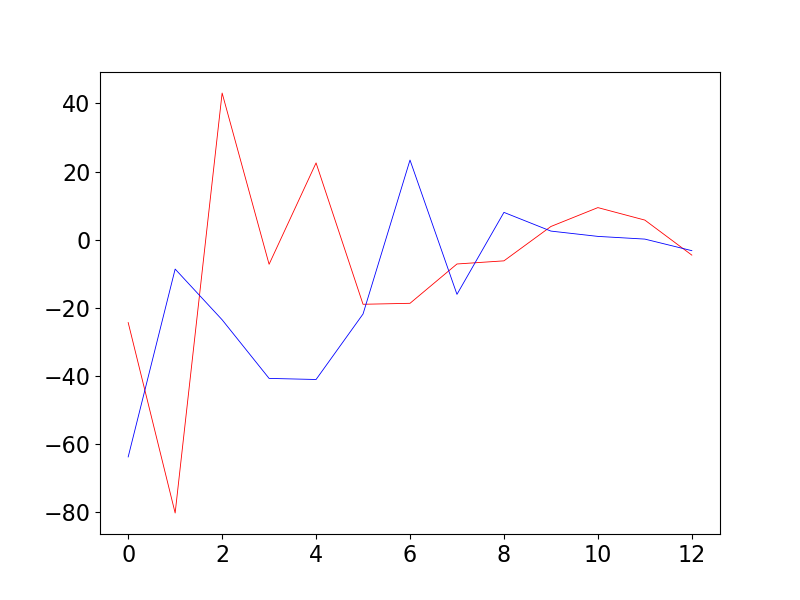

<IPython.core.display.Javascript object>


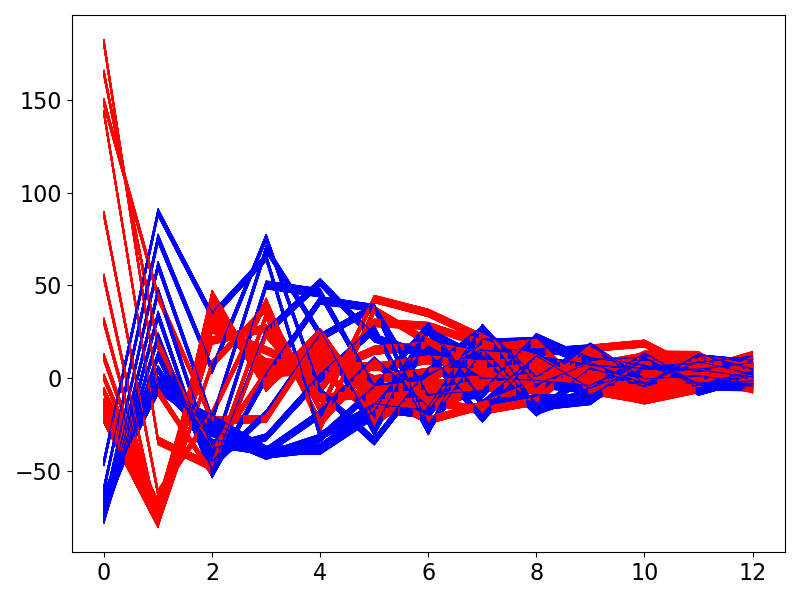

torch.Size([2828, 13])
torch.Size([2828, 13]) torch.Size([2828, 1]) <class 'torch.Tensor'>


In [27]:
# """
N = N_Compents

# p_num=[0,32 ,8,26, 14,30, 2,34, 3,31, 4,21, 10,23, 5,22, 7,27, 15,28, 16,29, 9,24] 
p_num_c0= [i for i in range(16)] #[0,2,4,5,7,8,10,15] #1 #5  class 0 class 1 class 0
p_num_c1= [i for i in np.arange(22,34)] #[22,24,28,30,32,34] #1 #5  class 0 class 1 class 0
p_num = p_num_c0 + p_num_c1
print(p_num)
N_TrainOrg = len(p_num)
Train_Gap = 10
X_2=torch.FloatTensor(X2_data)
Xtemp = torch.zeros(len(p_num),N_Compents)
X_Extrem_tmp = torch.empty(0,N_Compents)
for i in range(len(p_num)):
    Xtemp[i] = X_2[Train_Gap*p_num[i]] # intensity
    print(X_Extrem_tmp.shape,Xtemp[i].shape)
    X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp[i],(1,-1))),0)
print(Xtemp.shape)

X_Extrem= torch.empty(0,N_Compents)
X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.plot(Xtemp[0],lw=0.6,color='red')
ax.plot(Xtemp[-1],lw=0.6,color='blue')
N_sim=100 # number of simulated spectra for each original ones

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for n in range(N_sim):
    X_Extrem_tmp = torch.empty(0,N_Compents)
    seed = n*1000
    random.seed(seed)
    torch.manual_seed(seed)
    for j in range(len(p_num)):
        for i in range(N_Compents):
            Xtemp[j,i] = Xtemp[j,i] +random.random()/12
        ax.plot(Xtemp[j],lw=0.6,color='red' if j< len(p_num_c0) else 'blue')
        X_Extrem_tmp=torch.cat((X_Extrem_tmp,torch.reshape(Xtemp[j],(1,-1))),0)
    X_Extrem    =torch.cat((X_Extrem,X_Extrem_tmp),0) #  spectral curve are stacked in one column.
#     y_Extrem_tmp=torch.cat((ytemp1,ytemp2),0)
#     y_Extrem    =torch.cat((y_Extrem,y_Extrem_tmp),0)
# one row for one spectral curve:
print((X_Extrem).shape)

plt.tight_layout()


N_Train=N_TrainOrg*N_sim+N_TrainOrg


#  ===============================method 2============================
global X2,y2  
X2 = X_Extrem.to(device)
y2_orig = torch.cat((torch.zeros(len(p_num_c0),1),torch.ones(len(p_num_c1),1)),0)
y2 = torch.empty(0)
for n in range((N_sim+1)):
    y2= torch.cat([y2, y2_orig], dim=0) 

y2 = torch.reshape(y2,(-1,1)).to(device)
print(X2.shape,y2.shape,type(y2))

### data for testing

In [28]:
print(type(theta_t))

<class 'numpy.ndarray'>


# testing example input

In [29]:
# data for testing
global X2t,yt
print(X_2.shape)
Full_flag = 1
if Full_flag:
    X2t=X_2.to(device) # only use intensity information
else:
    Train_num = [Train_Gap*l for l in p_num];
#     print('Train_num:',Train_num)
    full_n = [i for i in range(len(X_2))]
    test_n = [x for x in full_n if (x not in Train_num)]
#     print('Test_num:',test_n)
    X2t = X_2[test_n,:].to(device)
    print('Test dataset:',X2t.shape)
    Ntn = Ntn-len(Train_num)

torch.Size([349, 13])


# training process

In [30]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = N_Compents
# N = np.size(theta[0])  # num_samples_per_class
D = 2  # dimensions
C = 2  # num_classes
H = 50 # num_hidden_units
B = 33 # num_bins
S = 0 #bin id
# Ntn= 2 # num_test_classes
Si=0
iternum= 15 if not standard_flag else 5
n_feature =20

global N2 
global N_Train

N2=int(N/B)

nn.Conv1d() applies 1D convolution over the input. nn.Conv1d() expects the input to be of the shape [batch_size, input_channels, signal_length] .
Conv1d — Input 2d
To apply 1D convolution on a 2d input signal, we can do the following. First, we define our input tensor of the size [1, 2, 5] where batch_size = 1, input_channels = 2 , and signal_length = 5 .


You are forgetting the "minibatch dimension", each "1D" sample has indeed two dimensions: the number of channels (7 in your example) and length (10 in your case). However, pytorch expects as input not a single sample, but rather a minibatch of B samples stacked together along the "minibatch dimension".
So a "1D" CNN in pytorch expects a 3D tensor as input: BxCxT. If you only have one signal, you can add a singleton dimension:

 out = model(torch.tensor(X)[None, ...])

In [31]:
# import math
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


# # Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
# class PositionalEncoding(nn.Module):
#     r"""Inject some information about the relative or absolute position of the tokens
#         in the sequence. The positional encodings have the same dimension as
#         the embeddings, so that the two can be summed. Here, we use sine and cosine
#         functions of different frequencies.
#     .. math::
#         \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
#         \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
#         \text{where pos is the word position and i is the embed idx)
#     Args:
#         d_model: the embed dim (required).
#         dropout: the dropout value (default=0.1).
#         max_len: the max. length of the incoming sequence (default=5000).
#     Examples:
#         >>> pos_encoder = PositionalEncoding(d_model)
#     """

#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         r"""Inputs of forward function
#         Args:
#             x: the sequence fed to the positional encoder model (required).
#         Shape:
#             x: [sequence length, batch size, embed dim]
#             output: [sequence length, batch size, embed dim]
#         Examples:
#             >>> output = pos_encoder(x)
#         """

#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)

# class TransformerModel(nn.Module):
#     """Container module with an encoder, a recurrent or transformer module, and a decoder."""

#     def __init__(self, d_input=4023, d_model=256, nhead=8, nhid=256, nlayers=8, dropout=0.0, o_feature = 1,n_feature= 32,n_feature_embd = 8,):
#         super(TransformerModel, self).__init__()
#         try:
#             from torch.nn import TransformerEncoder, TransformerEncoderLayer
#         except:
#             raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
#         self.model_type = 'Transformer'
#         self.src_mask = None
# #         self.encoder = nn.Linear(d_input, d_model)
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
#         encoder_layers = TransformerEncoderLayer(d_model, nhead, nhid, dropout)
#         self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
#         self.d_model = d_model
# #         self.decoder = nn.Linear(d_model, o_feature)


#         self.conv1_embd = nn.Sequential(nn.Conv1d(1, n_feature_embd, kernel_size=3,stride=2)
# #                                    nn.ReLU(),
# #                                    nn.MaxPool1d(2)
#                                    )
#         input_shape_embd = (1, 1, d_input) # just for test, in order to get the shape of FNN input neurons            
#         self.output_dimension_embd = self._get_conv_embd_output(input_shape_embd)

#         self.fc1_embd = nn.Linear(self.output_dimension_embd, d_model)
# #         n.Sequential(
# #             nn.Linear(self.output_dimension_embd, d_model),
# #             nn.Sigmoid()
# #         )
        


#         self.conv1 = nn.Sequential(nn.Conv1d(1, n_feature, kernel_size=5,stride=2),
#                                    nn.ReLU(),
#                                    nn.MaxPool1d(2)
#                                    )
#         input_shape = (1, 1, d_model) # just for test, in order to get the shape of FNN input neurons            
#         self.output_dimension = self._get_conv_output(input_shape)

#         self.fc1 = nn.Sequential(
#             nn.Linear(self.output_dimension, o_feature),          
#             nn.Sigmoid()
#         )
        
        
# #         self.decoder = nn.Sequential(
# # #             nn.Linear(d_model, d_model),
# # #             nn.ReLU(),
# #             nn.Linear(d_model, o_feature),
# #             nn.Sigmoid()
# #             )

# #         self.init_weights()
#     def _get_conv_embd_output(self, shape):
#         x = torch.rand(shape)
#         x = self.conv1_embd(x)
#         x = x.view(x.size(0), -1)
#         output_dimension = x.size(1)
#         return output_dimension
                    
#     def _get_conv_output(self, shape):
#         x = torch.rand(shape)
#         x = self.conv1(x)
#         x = x.view(x.size(0), -1)
#         output_dimension = x.size(1)
#         return output_dimension
    
#     def _generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

# #     def init_weights(self):
# #         initrange = 0.1
# #         nn.init.uniform_(self.encoder.weight, -initrange, initrange)
# # #         nn.init.zeros_(self.decoder.weight)
# # #         nn.init.uniform_(self.decoder.weight, -initrange, initrange)

#     def forward(self, src, has_mask=False):
#         if has_mask:
#             device = src.device
#             if self.src_mask is None or self.src_mask.size(0) != len(src):
#                 mask = self._generate_square_subsequent_mask(len(src)).to(device)
#                 self.src_mask = mask
#         else:
#             self.src_mask = None
       
#         src  = torch.reshape(src,(-1,1,N_Compents))
#         src  = self.conv1_embd(src)  
#         src  = src.view(src.size(0), -1)
#         src  = self.fc1_embd(src)
#         src = src[None]
# #         print('src',src.shape)
# #         src = self.encoder(src)
# #         src = self.encoder(src) * math.sqrt(self.d_model)
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src, self.src_mask)
#         output = torch.reshape(output,(-1,1,self.d_model))
#         output  = self.conv1(output)  
#         output  = output.view(output.size(0), -1)
#         output  = self.fc1(output)
# #         print('After encoder:',output.shape)
# #         output = self.decoder(output)
# #         print('After decoder:',output.shape)
# #         return F.log_softmax(output, dim=-1)
#         return output

In [32]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, d_input=4023, d_model=256, nhead=8, nhid=128, nlayers=8, dropout=0.0, o_feature = 1,n_feature= 32,n_feature_embd = 8,):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.src_mask = None
        self.encoder = nn.Linear(d_input, d_model)
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
#         self.decoder = nn.Linear(d_model, o_feature)




#         self.conv1 = nn.Sequential(nn.Conv1d(1, n_feature, kernel_size=5,stride=2),
#                                    nn.ReLU(),
#                                    nn.MaxPool1d(2)
#                                    )
        
#         input_shape = (1, 1, d_model) # just for test, in order to get the shape of FNN input neurons            
#         self.output_dimension = self._get_conv_output(input_shape)

        self.fc1 = nn.Sequential(
            nn.Linear(d_model, o_feature),          
            nn.Sigmoid()
        )
        
        
#         self.decoder = nn.Sequential(
# #             nn.Linear(d_model, d_model),
# #             nn.ReLU(),
#             nn.Linear(d_model, o_feature),
#             nn.Sigmoid()
#             )

#         self.init_weights()

                    
#     def _get_conv_output(self, shape):
#         x = torch.rand(shape)
#         x = self.conv1(x)
#         x = x.view(x.size(0), -1)
#         output_dimension = x.size(1)
#         return output_dimension
    
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

#     def init_weights(self):
#         initrange = 0.1
#         nn.init.uniform_(self.encoder.weight, -initrange, initrange)
# #         nn.init.zeros_(self.decoder.weight)
# #         nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=False):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
        
        src  = torch.reshape(src,(-1,1,N_Compents))
        src  = self.encoder(src)

#         src  = src[None]
#         print('src',src.shape)
#         src = self.encoder(src) * math.sqrt(self.d_model)
#         src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
#         output = torch.reshape(output,(-1,1,self.d_model))
#         output  = self.conv1(output)  
#         output  = output.view(output.size(0), -1)
        output = torch.reshape(output,(-1,self.d_model))
        output  = self.fc1(output)
#         print('After encoder:',output.shape)
#         output = self.decoder(output)
#         print('After decoder:',output.shape)
#         return F.log_softmax(output, dim=-1)
        return output

In [33]:
d_input = N_Compents
d_model = 16 if not standard_flag else 256
print(d_input, d_model)
model = TransformerModel(d_input = d_input,d_model = d_model, nhead=8, nlayers=1)
model.to(device)

# src = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
# out = transformer_model(src)

13 16


TransformerModel(
  (encoder): Linear(in_features=13, out_features=16, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=128, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=128, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (fc1): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [34]:
for name,param in model.named_parameters():
    print(name,type(param), param.size())
### in_features*3 (key, query, value)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('pytorch_total_params:',pytorch_total_params)

encoder.weight <class 'torch.nn.parameter.Parameter'> torch.Size([16, 13])
encoder.bias <class 'torch.nn.parameter.Parameter'> torch.Size([16])
transformer_encoder.layers.0.self_attn.in_proj_weight <class 'torch.nn.parameter.Parameter'> torch.Size([48, 16])
transformer_encoder.layers.0.self_attn.in_proj_bias <class 'torch.nn.parameter.Parameter'> torch.Size([48])
transformer_encoder.layers.0.self_attn.out_proj.weight <class 'torch.nn.parameter.Parameter'> torch.Size([16, 16])
transformer_encoder.layers.0.self_attn.out_proj.bias <class 'torch.nn.parameter.Parameter'> torch.Size([16])
transformer_encoder.layers.0.linear1.weight <class 'torch.nn.parameter.Parameter'> torch.Size([128, 16])
transformer_encoder.layers.0.linear1.bias <class 'torch.nn.parameter.Parameter'> torch.Size([128])
transformer_encoder.layers.0.linear2.weight <class 'torch.nn.parameter.Parameter'> torch.Size([16, 128])
transformer_encoder.layers.0.linear2.bias <class 'torch.nn.parameter.Parameter'> torch.Size([16])
tra

# pick two extreme curves for training

In [35]:
print(y2.shape,len(y2))

torch.Size([2828, 1]) 2828


In [36]:
# train NN in each bin
def TrainingProc():
    global X2,y2
#     X2 = torch.zeros(N2 * N_Train, D*B).to(device)
#     y2 = torch.zeros(N2 * N_Train, 1, dtype=torch.float).to(device)    
    
#     for b in range(B):
#         for ix in range(N2):
#             for ic in range(N_Train):
#                 X2[ix+ic*N2,2*b:2*b+2] = X_Extrem[b*N2+ix+ic*N]
#                 y2[ix+ic*N2] = y_Extrem[b*N2+ix+ic*N]
    #print("X2:", tuple(X2.size()))
    #print("y2:", tuple(y2.size()))
    #print('y2.shape',y2.shape)
    
    learning_rate = 2e-3  # 8e-3
    lambda_l2 = 2e-5
    # nn package to create our linear model
    # each Linear module has a weight and bias


    # nn package also has different loss functions.
    # we use cross entropy loss for our classification task
    criterion = torch.nn.BCELoss()

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
    #optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, betas=(0.8, 0.999), eps=1e-08, weight_decay=0) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    dh=display.display("Training",display_id=True)
    for t in range(iternum):
        # Feed forward to get the logits
        y_pred = model(X2)
#         print(y_pred)
        y_pred = y_pred.squeeze(0)
#         y_pred = model(X_Extrem_x,X_Extrem_y)
#         print(y_pred.shape)
        # Compute the loss and accuracy
        loss = criterion(y_pred, y2)
        predicted = y_pred > 0.5
#         print(y2,predicted)
        acc = (y2 == predicted).sum().float() / len(y2)
        dh.update(" [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % ( t, loss.item(), acc))
        #display.clear_output(wait=True)
              
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
    
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
    
        # Update params
        optimizer.step()
        
    #print(len(y2),y_pred.size(),loss,sep='\n') 
    return acc
#     return acc,model

In [37]:
# pick two extreme curves for training and generate test data in each bin
global Acc,N2
N2=int(N/B)
ytest_pred=[]
# print(y2.t())
# ====================training=======================
from time import time
t0= time()
Acc =TrainingProc()  
t1= time()
print("training done in %0.3fs" % (t1 - t0))
with torch.no_grad(): 
    y_pred= model(X2) # 
    
    y_pred= y_pred.squeeze(0)
#     y_pred = model(X_Extrem_x,X_Extrem_y)

print(y_pred.shape)

' [EPOCH]: 14, [LOSS]: 0.113147, [ACCURACY]: 1.000'

training done in 0.317s
torch.Size([2828, 1])


In [38]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    1.3 GB


In [39]:
with torch.no_grad(): 
    y_pred= model(X2) # 
y_pred = y_pred>0.5
y_pred = y_pred.squeeze(0)
#     y_pred = model(X_Extrem_x,X_Extrem_y)

print(y_pred[0:10].t(),y_pred.shape)

tensor([[False, False, False, False, False, False, False, False, False, False]],
       device='cuda:0') torch.Size([2828, 1])


In [40]:
print(X2t.shape,X2.shape)
print(X2.shape,X2t.shape,N)

torch.Size([349, 13]) torch.Size([2828, 13])
torch.Size([2828, 13]) torch.Size([349, 13]) 13


In [41]:
print(X2t.shape)
with torch.no_grad(): 
    y2t = model(X2t)# use model in each bin to predict label of test data curves belong to each bin             
y2t_pred = y2t>0.5 
y2t_pred = torch.squeeze(y2t_pred)
# FinlPredLabel =y2t_pred.cpu().numpy().astype(int)
FinlPredLabel =1*y2t_pred.cpu()
print(y2t_pred[1:5],y2t_pred.shape)

print(FinlPredLabel.shape,FinlPredLabel)
        

torch.Size([349, 13])
tensor([False, False, False, False], device='cuda:0') torch.Size([349])
torch.Size([349]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        

# Curve-wise ambigious region 

In [42]:
    var_C0=0 # initial value of class 0;
    Ntn=y2t_pred.shape[0]
    for j in range(Ntn-1): # test data sets(curves)    
        if (FinlPredLabel[j] == 0) and (FinlPredLabel[(j+1)]==0):
            var_C0 = j+1
        else:
            break  
    var_C1=Ntn-1 # initial value of class 1; So after iteration, if var_C1=Ntn-1(still this value), it means the following conditions are not met.
    for j in range(Ntn-1,0,-1): # test data sets(curves)   
        if (FinlPredLabel[j] == 1) and (FinlPredLabel[(j-1)]==1):
            var_C1 = j-1
        else:
            break
    torch.set_printoptions(threshold=10_000)
    np.set_printoptions(threshold=10_000)
     
    if var_C0==Ntn-1:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 0.")
    elif var_C1==0:
        Glo_acc = 0.50
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found and all curves are labeled as 1.")
    elif var_C0==0 and var_C1==Ntn-1:
        Glo_acc = 0.00
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("The boundary is not found  and all curves are labeled as 1." )
    else:
        Glo_acc = 1-float((var_C1-var_C0-1)/Ntn)
        print("Interval with low classification confidence is (%i ,  %i)" % (var_C0,  var_C1))
        print("Overall classification accuracy is %.3f" % (Glo_acc*100)+"%")
    

Interval with low classification confidence is (203 ,  204)
Overall classification accuracy is 100.000%


In [43]:
# print(FinlPredLabel[p0_num*gap])
# print(FinlPredLabel[p_num*gap])
print(FinlPredLabel[p_num[0]*Train_Gap])
print(FinlPredLabel[p_num[1]*Train_Gap])
print(FinlPredLabel[p_num[2]*Train_Gap])
print(FinlPredLabel[p_num[3]*Train_Gap])

tensor(0)
tensor(0)
tensor(0)
tensor(0)
